In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content="Answer all questions to the best of your ability."),
    MessagesPlaceholder(variable_name="messages")
])

model = ChatOllama(model="llama3.1")

chain = prompt | model

ai_msg = chain.invoke(
    {"messages": [
        HumanMessage(content="translate from english to french: I love programming."),
        AIMessage(content="J'adore la progrmamation."),
        HumanMessage(content="What did you just say?")
    ]}
)
print(ai_msg.content)

I translated "I love programming" into French, which is:

"J'adore la programmation."

(Note: I made a small correction to the original translation)


In [ ]:
#pip install langgraph


In [2]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

In [3]:
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.1")

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

builder.add_node("chatbot", chatbot)

In [4]:
builder.add_edge(START,"chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

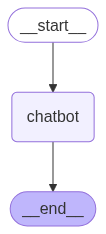

In [5]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))


In [6]:
input = {"messages": [HumanMessage("hi!")]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content="Hello! How's your day going so far? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-09-08T09:00:12.190952588Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8717046124, 'load_duration': 114994958, 'prompt_eval_count': 12, 'prompt_eval_duration': 1512691712, 'eval_count': 26, 'eval_duration': 7088875061, 'model_name': 'llama3.1'}, id='run--bcc9d910-1e70-4ab0-8842-8641abd966d5-0', usage_metadata={'input_tokens': 12, 'output_tokens': 26, 'total_tokens': 38})]}}


In [19]:
# Page:105
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

In [25]:
thread1 = {"configurable": {"thread_id": "1"}}

# Run first interaction
result_1 = graph.invoke({"messages": [HumanMessage("hi, my name is Jack!")]}, config=thread1)
print("Result 1 (current response):", result_1)

# Run follow-up interaction
result_2 = graph.invoke({"messages": [HumanMessage("what is my name?")]}, config=thread1)
print("Result 2 (current response):", result_2)

state_snapshot = graph.get_state(config=thread1)
state = state_snapshot.values  # Extract the dict holding state values

print("Full conversation history in state:")
for msg in state["messages"]:
    role = "AI" if isinstance(msg, AIMessage) else "Human"
    print(f"{role}: {msg.content}")



Result 1 (current response): {'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='1e7168c1-c05d-45e0-b507-f6b16595c766'), AIMessage(content="I don't have any information about your name. Our conversation just started, and I'm a large language model, I don't retain any information about individual users. If you'd like to share your name with me, I can use it in our conversation!", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-08-30T19:35:59.588581901Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17693786056, 'load_duration': 116856686, 'prompt_eval_count': 15, 'prompt_eval_duration': 1558665573, 'eval_count': 53, 'eval_duration': 16017721659, 'model_name': 'llama3.1'}, id='run--05615d6e-0ce5-4bfa-bde6-3cb6dd25dba1-0', usage_metadata={'input_tokens': 15, 'output_tokens': 53, 'total_tokens': 68}), HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='ef6

In [26]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='1e7168c1-c05d-45e0-b507-f6b16595c766'), AIMessage(content="I don't have any information about your name. Our conversation just started, and I'm a large language model, I don't retain any information about individual users. If you'd like to share your name with me, I can use it in our conversation!", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-08-30T19:35:59.588581901Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17693786056, 'load_duration': 116856686, 'prompt_eval_count': 15, 'prompt_eval_duration': 1558665573, 'eval_count': 53, 'eval_duration': 16017721659, 'model_name': 'llama3.1'}, id='run--05615d6e-0ce5-4bfa-bde6-3cb6dd25dba1-0', usage_metadata={'input_tokens': 15, 'output_tokens': 53, 'total_tokens': 68}), HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='ef6bad90-76

In [28]:
graph.update_state(thread1, {"messages": [HumanMessage("I like LLMs!")]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f085df8-0aa2-6956-801d-ba518607e410'}}

In [33]:
# Page:108
from langchain_ollama import ChatOllama
from langchain_core.messages import trim_messages, SystemMessage

trimmer = trim_messages(
        max_tokens=65,
        strategy="last",
        token_counter=ChatOllama(model="llama3.1"),
        include_system=True,
        allow_partial=False,
        start_on="human"
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]
trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [35]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages,
)

# Sample messages
messages = [
    SystemMessage(content="you are a good assistant", id="1"),
    HumanMessage(content="example input", id="2", name="example_user"),
    AIMessage(content="example output", id="3", name="example_assistant"),
    HumanMessage(content="real input", id="4", name="bob"),
    AIMessage(content="real output", id="5", name="alice"),
]

# Filter for human messages
human_messages = filter_messages(messages, include_types="human")
print("Human messages:", human_messages)

# Filter to exclude certain names
excluded_names = filter_messages(
    messages, exclude_names=["example_user", "example_assistant"]
)
print("\nExcluding example names:", excluded_names)

# Filter by types and IDs
filtered_messages = filter_messages(
    messages, include_types=["human", "ai"], exclude_ids=["3"]
)
print("\nFiltered by types and IDs:", filtered_messages)

Human messages: [HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

Excluding example names: [SystemMessage(content='you are a good assistant', additional_kwargs={}, response_metadata={}, id='1'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

Filtered by types and IDs: [HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]


In [36]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    merge_message_runs,
)

# Sample messages with consecutive messages of same type
messages = [
    SystemMessage(content="you're a good assistant."),
    SystemMessage(content="you always respond with a joke."),
    HumanMessage(
        content=[{"type": "text", "text": "i wonder why it's called langchain"}]
    ),
    HumanMessage(content="and who is harrison chasing anyways"),
    AIMessage(
        content='Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!'
    ),
    AIMessage(
        content="Why, he's probably chasing after the last cup of coffee in the office!"
    ),
]

# Merge consecutive messages
merged = merge_message_runs(messages)
print(merged)

[SystemMessage(content="you're a good assistant.\nyou always respond with a joke.", additional_kwargs={}, response_metadata={}), HumanMessage(content=[{'type': 'text', 'text': "i wonder why it's called langchain"}, 'and who is harrison chasing anyways'], additional_kwargs={}, response_metadata={}), AIMessage(content='Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!\nWhy, he\'s probably chasing after the last cup of coffee in the office!', additional_kwargs={}, response_metadata={})]
